## Read CSV file and create a graph

In [149]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [150]:
version = '0.1.2'
file_name = 'novels_' + version + '.csv'

In [153]:
df = pd.read_csv(file_name, na_values='NaN')
df = df.iloc[:200]

g = nx.Graph()

# Add nodes
g.add_nodes_from(df['id'].values)

#TODO: Add colors depending on genre (ordered priority)

# Add edges
edge_attr = 'recommended_series_ids'
df_edge = df.loc[~df[edge_attr].isnull()].copy()
df_edge[edge_attr] = df_edge.loc[:, edge_attr].str.strip('[]').str.split(',')
edges = [(novel[0], int(edge)) for novel in df_edge[['id', edge_attr]].values for edge in novel[1]]
g.add_edges_from(edges)

print('Number of nodes:', g.number_of_nodes())
print('Number of edges:', g.number_of_edges())


Number of nodes: 697
Number of edges: 739


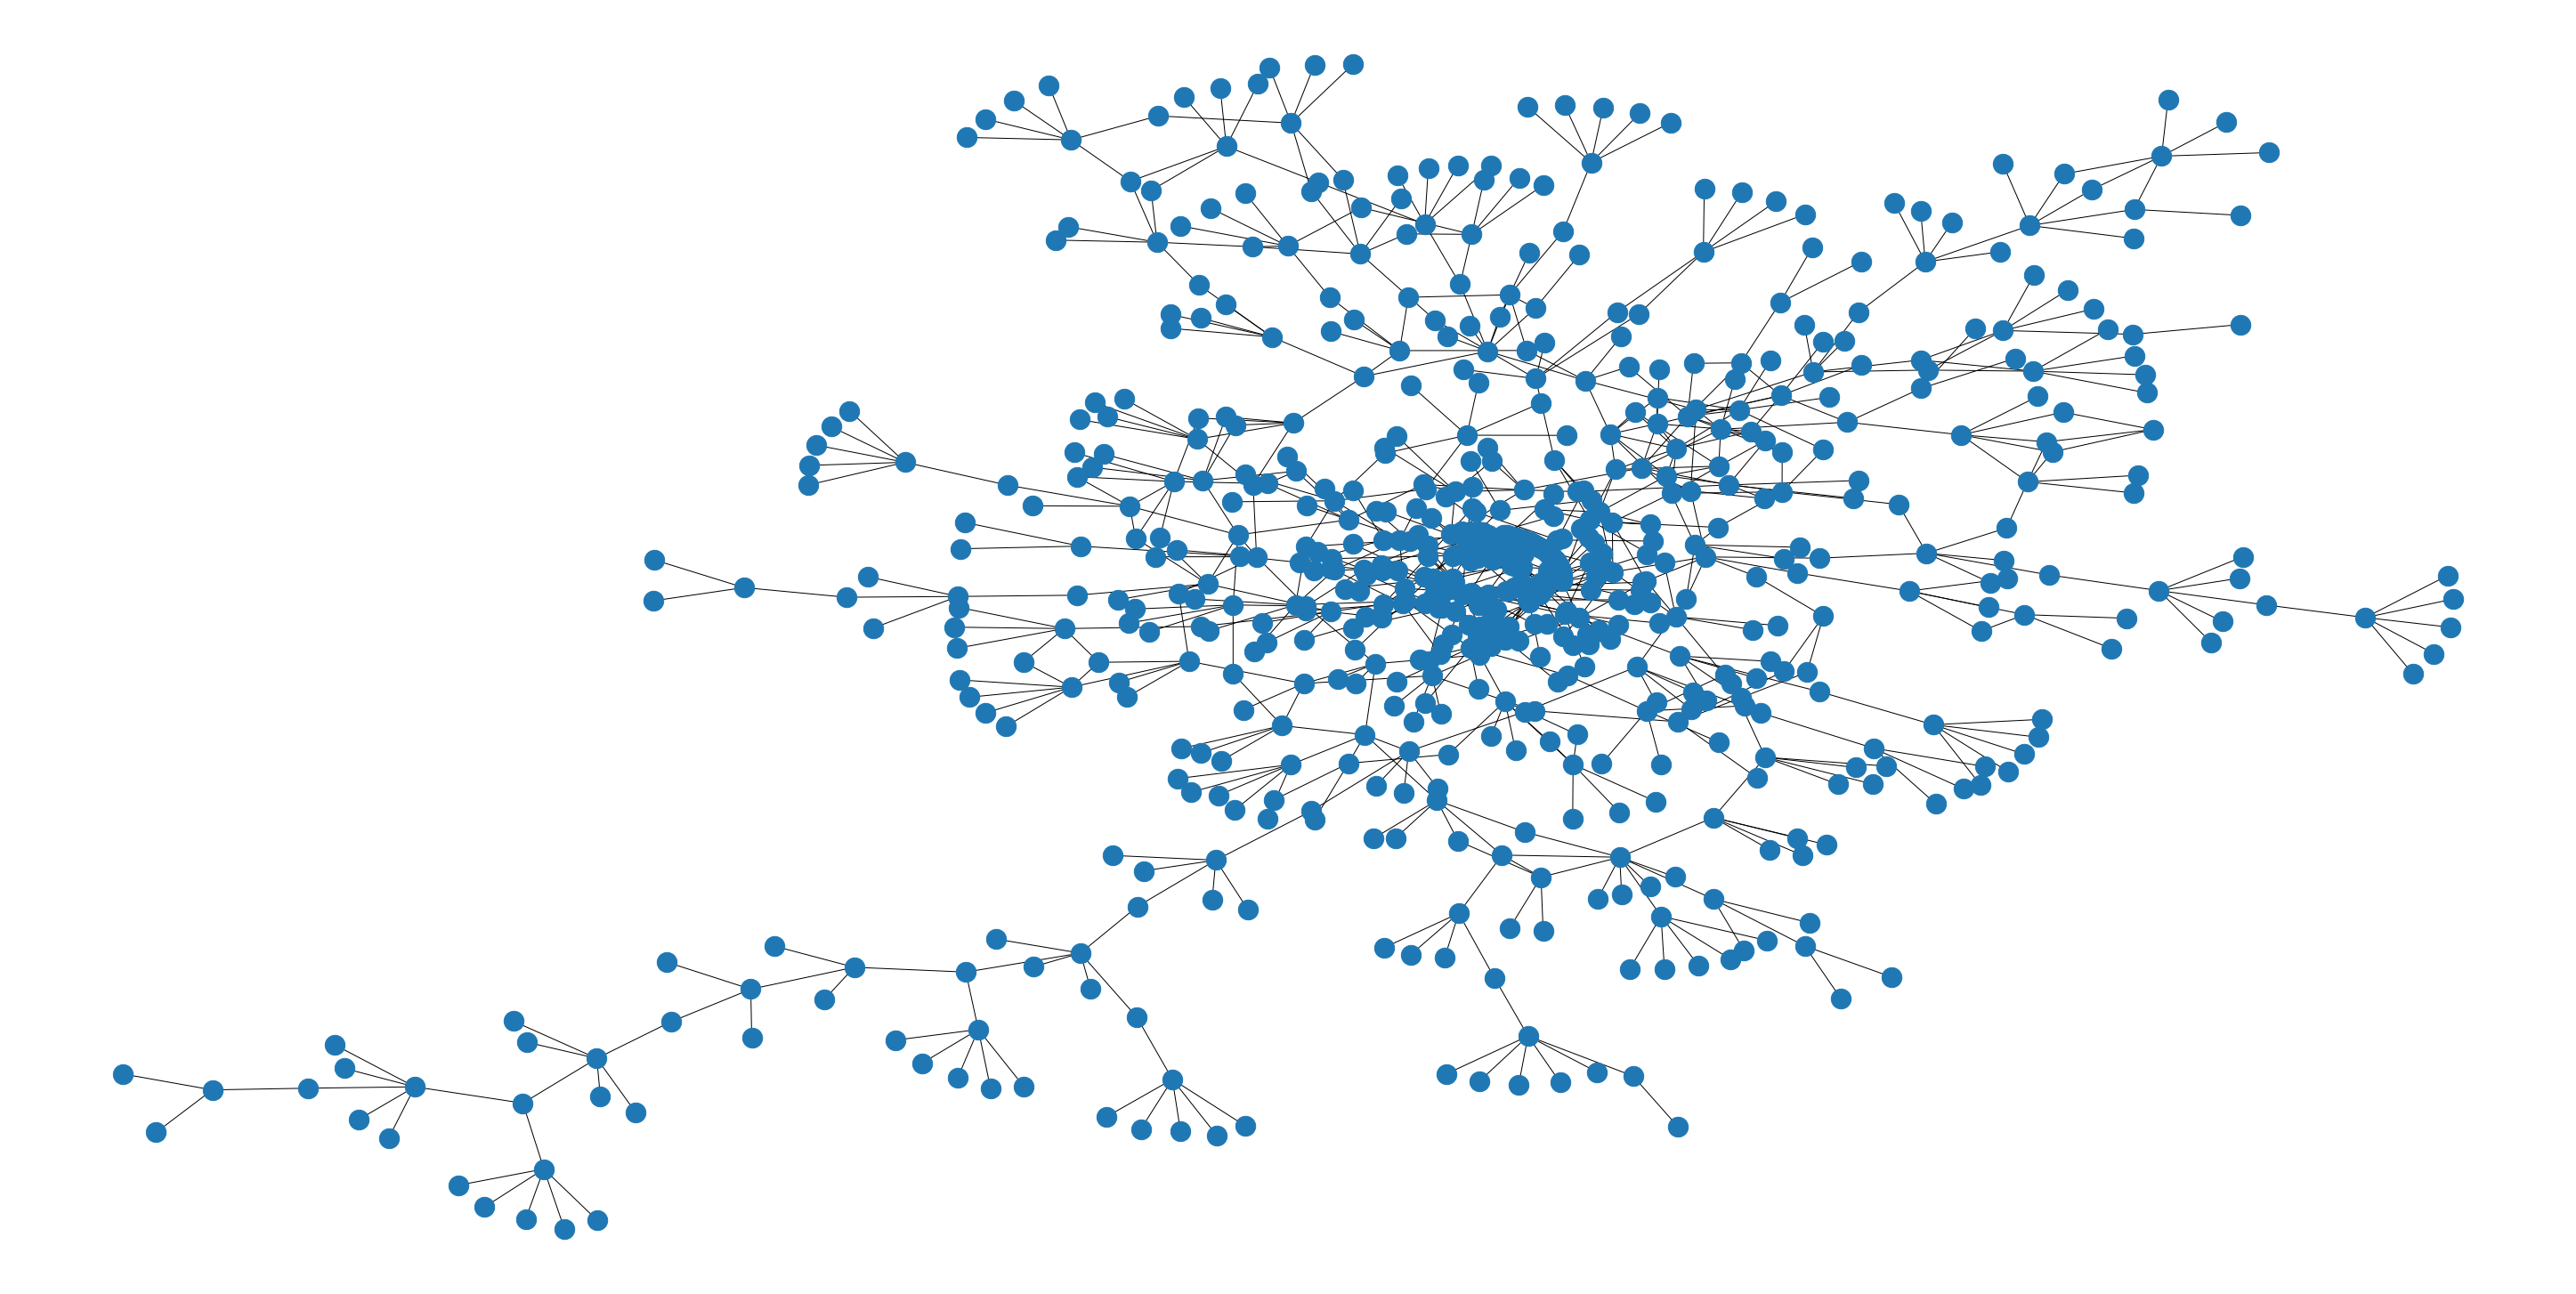

In [154]:
fig = plt.figure(figsize=(40, 20)) 
#nx.draw_kamada_kawai(g, node_size=500) 
nx.draw_kamada_kawai(g, node_size=500) 
#plt.axis('equal') 
plt.show() 
fig.savefig('graph.svg') 